In [1]:
source("~/ws/my.source.R")
options(stringsAsFactors=F)

suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(cowplot))

suppressPackageStartupMessages(library(ggbeeswarm))
suppressPackageStartupMessages(library(ggrepel))

suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(ggsci))
source("~/ws/colors.R")

In [47]:
## e.g., NaiveCD4, disease-activity
lineage_tmp = "CD4"
celltype_tmp  = "NaiveCD4"
compare_tmp  = "HDAvsInactive"
cov_tmp      = "sexpopcellnum"
mincell_tmp = 10
PC_tmp   =20
sigma_tmp=0.25
res_tmp=0.35

# color scale: max 0.6
myPalette = colorRampPalette(c(RColorBrewer::brewer.pal(9, "RdBu")[9:6], "#DCDCDC", RColorBrewer::brewer.pal(9, "RdBu")[4:1]))
limit=0.6

In [48]:
##############
# Fig.3b: UMAP
##############

# UMAP
umap_post=fread_FT(paste0("data/",lineage_tmp,"_",celltype_tmp,"_mincell",mincell_tmp,"_PC",PC_tmp,"_sigma",sigma_tmp,"_postUMAP.txt"))
dim(umap_post)%>%print()

[1] 216692      3


In [49]:
# CNA result
cna_res_tmp=readRDS(paste0("data/",celltype_tmp,"_",compare_tmp,"_CNA_res.rds"))
fdr_10p_tmp=cna_res_tmp$fdr_10p_t
fdr_5p_tmp =cna_res_tmp$fdr_5p_t
corr_tmp   =cna_res_tmp$ncorrs%>%as.data.frame()%>%rownames_to_column("cell_id")
colnames(corr_tmp)[2]="corr"

In [50]:
corr_tmp2=corr_tmp%>%left_join(.,umap_post,by="cell_id")

dim(corr_tmp2)%>%print() # only CLUES cells

if(is.null(fdr_10p_tmp)){fdr_10p_tmp=NA}
if(is.null(fdr_5p_tmp)){fdr_5p_tmp=NA}

corr_tmp2=corr_tmp2%>%mutate(corr=ifelse(corr>limit,limit,
                                  ifelse(corr<(-limit),-limit,corr)))%>% # upper/lower limit
                      mutate(corr_sig=ifelse(abs(corr)>fdr_5p_tmp,corr,0))
corr_tmp2$corr_sig[is.na(corr_tmp2$corr_sig)]=0
# color: only neighborhoods with FDR<0.05

[1] 143650      4


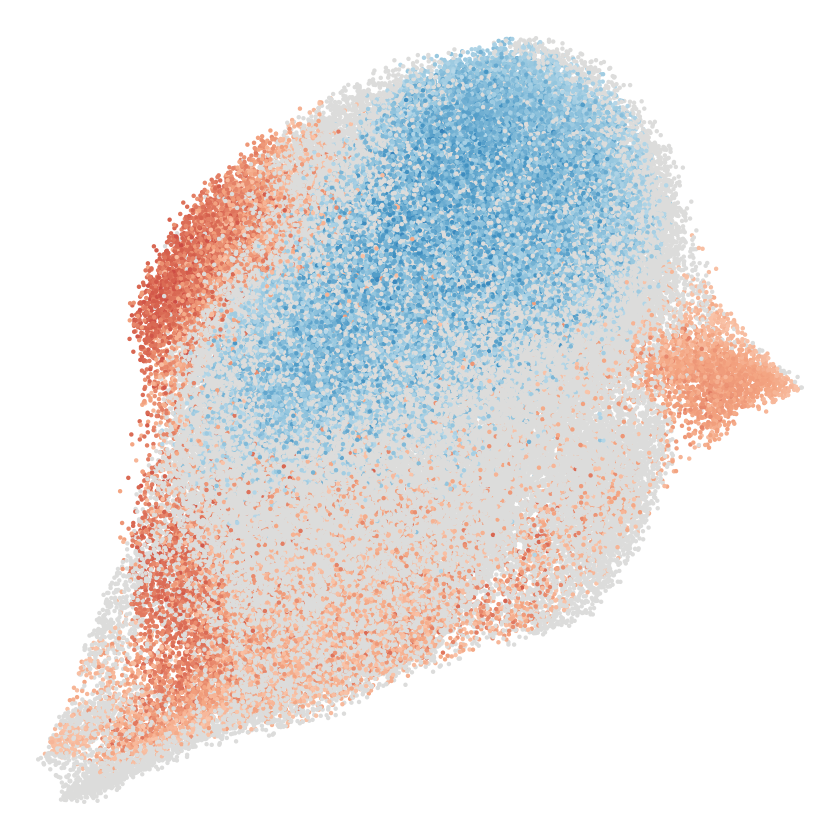

In [51]:
ggplot(corr_tmp2,aes(x=UMAP_1,y=UMAP_2,color=corr_sig))+
     geom_point(size=0.2)+
     theme_void()+
     scale_colour_gradientn(na.value="lightgray",colors = myPalette(100), limits = c(-limit,limit)) + 
     theme(axis.text.x=element_blank(),
           axis.text.y=element_blank(),
           axis.title.x=element_blank(),
           axis.title.y=element_blank(),
           plot.title=element_blank(),
           legend.position="none")

In [52]:
##############
# Fig.3b: Violinplot
##############

# cell state info
R4_C0=fread_FT(paste0("data/",lineage_tmp,"_",celltype_tmp,"_mincell",mincell_tmp,"_PC",PC_tmp,"_sigma",sigma_tmp,"_res_",res_tmp,"_idlist.txt"))%>%
      mutate(anno_final=ifelse(cluster==0,"NaiveCD4-0",
                     ifelse(cluster==1,"NaiveCD4-1",
                     ifelse(cluster==2,"NaiveCD4-2",
                     ifelse(cluster==4,"NaiveCD4-3",
                     ifelse(cluster==3,"NaiveCD4-4",
                     ifelse(cluster==5,"NaiveCD4-5",
                     ifelse(cluster==6,"NaiveCD4-6",NA
                     ))))))))
table(R4_C0$anno_final)


NaiveCD4-0 NaiveCD4-1 NaiveCD4-2 NaiveCD4-3 NaiveCD4-4 NaiveCD4-5 NaiveCD4-6 
     81706      58974      40457      11490      14515       5849       3701 

In [53]:
corr_tmp3=corr_tmp%>%inner_join(.,R4_C0%>%select(cell_id,anno_final),by="cell_id")
dim(corr_tmp3)%>%print()

[1] 143650      3


In [54]:
corr_tmp3$anno_final=factor(corr_tmp3$anno_final,levels=rev(sort(unique(corr_tmp3$anno_final))))

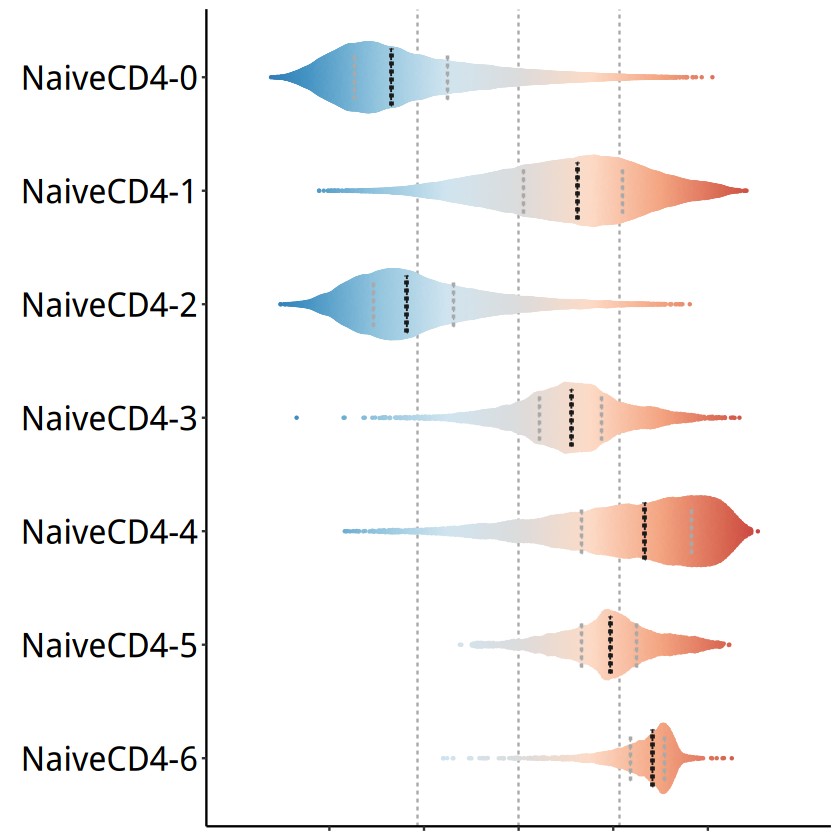

In [55]:
ggplot(corr_tmp3,aes(x=anno_final,y=corr))+
         coord_flip()+
         geom_hline(yintercept=fdr_5p_tmp, col="darkgrey",linetype="dashed")+
         geom_hline(yintercept=-fdr_5p_tmp,col="darkgrey",linetype="dashed")+
         geom_hline(yintercept=0,col="darkgrey",linetype="dashed")+
         geom_quasirandom(aes(color=corr),width=0.3,size=0.2) +
         stat_summary(aes(group=anno_final),fun=function(x){quantile(x,0.25,type=1)},fun.min=function(x){quantile(x,0.25,type=1)},fun.max=function(x){quantile(x,0.25,type=1)},geom="crossbar",color="darkgrey",width=0.4,lwd=0.3,linetype="dashed")+
         stat_summary(aes(group=anno_final),fun=function(x){quantile(x,0.75,type=1)},fun.min=function(x){quantile(x,0.75,type=1)},fun.max=function(x){quantile(x,0.75,type=1)},geom="crossbar",color="darkgrey",width=0.4,lwd=0.3,linetype="dashed")+
         stat_summary(aes(group=anno_final),fun=median,fun.min=median,fun.max=median,geom="crossbar",color="grey10",width=0.5,lwd=0.4,linetype="dashed")+
         theme_classic()+
         scale_colour_gradientn(na.value="lightgray",colors=myPalette(100),limits=c(-0.6,0.6)) + 
         theme(axis.text.x=element_blank(),
               axis.text.y=element_text(colour="black",size=20),
               axis.title.x=element_blank(),
               axis.title.y=element_blank(),
               plot.title=element_blank(),
               legend.position="none")+
         scale_y_continuous(limits=c(-0.6,0.6),breaks=seq(-0.4,0.4,by=0.2))

In [56]:
## This is Supple Fig. 4b (NaiveCD4, disease-activity)
## In Fig. 3b, I limited to only expanded cell states (NaiveCD4-4,5,6)